#### Known error: This notebook requires [yt](https://yt-project.org/) to visualize the results. Yt needs to be updated to work properly first. Updates are currently being made to yt's frontends to make this PyNE integration work.

# Let's Explore PyNE Meshes!

In [1]:
from pyne.xs.channels import sigma_t
from pyne.material import Material, from_atom_frac
from pyne.mesh import Mesh, NativeMeshTag, MetadataTag, ComputedTag
from yt.config import ytcfg; ytcfg["yt","suppressStreamLogging"] = "True"
from yt.mods import *

First, let's create a 2D structured mesh, whose grid points in x & y are [Cantor dust](http://en.wikipedia.org/wiki/Cantor_set#Cantor_dust).  Most of the mesh will have water as a coolant.  Some volume elements will have fuel, though.

In [2]:
def cantor(n):
    return [0.] + cant(0., 1., n) + [1.]

def cant(x, y, n):
    if n == 0:
        return []
    new_pts = [2.*x/3. + y/3., x/3. + 2.*y/3.]
    return cant(x, new_pts[0], n-1) + new_pts + cant(new_pts[1], y, n-1)

In [3]:
c5 = cantor(5)
coords = [c5, c5, [0.0, 1.0]]

We access volume elements (`ve`) on the mesh through a volume element index (`idx`).  This index is a unique integer `i` that gives a sort ordering to an otherwise unorder mesh.  The volume element index is defined on the range from 0 (inclusive) to the number of volumes in the mesh (exclusive).  You may access a volume element's material through the `mats` attribute and indexing with `i`.

In [4]:
m = Mesh(structured_coords=coords, structured=True)
fuel = from_atom_frac({'U235': 0.045, 'U238': 0.955, 'O16': 2.0}, density=10.7)
cool = from_atom_frac({'H1': 2.0, 'O16': 1.0}, density=1.0)
for i in range(len(m)):
    m.mats[i] = cool
m.mats[len(m)/2] = fuel
m.mats[len(m)/4] = fuel
for i, c in enumerate(c5[:-1]):
    m.mats[i*len(c5)] = fuel

## Tags

`Tag`s - sometimes known as fields - are generic way of storing data on a mesh.  Tags can be accessed as attributes on the mesh class itself.  For example, the density tag may be grabbed via:

In [5]:
m.density 

MaterialPropertyTag(name='density', doc='the density [g/cc]')

To get the value of the density, you have to provide the location by its index.

In [6]:
m.density[42]

1.0

You can also slice, mask, or fancy index tags:

In [7]:
print(m.density[::100])  # slice

[ 10.7   1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.   10.7   1.    1.    1.    1.    1.    1.    1.
   1.    1.    1.    1.    1.    1.    1.    1.   10.7   1.    1.    1.
   1.    1.    1.    1. ]


In [8]:
print(m.density[m.density[:] >= 10])  # mask

[ 10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7
  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7
  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7
  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7
  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7  10.7
  10.7  10.7  10.7  10.7]


In [9]:
print(m.density[[10, 0, 11, 100]])  # fancy index is fancy

[  1.   10.7   1.    1. ]


To get a list of all current tag names, uses the `tags` dictionary on the mesh:

In [10]:
m.tags.keys()

['sub_act',
 'sub_lan',
 'number_density',
 'density',
 'comp',
 'expand_elements',
 'to_atom_frac',
 'molecular_weight',
 'mass_density',
 'atoms_per_mol',
 'sub_tru',
 'mass',
 'attrs',
 'mult_by_mass',
 'sub_ma',
 'idx',
 'sub_fp']

## Analysis & Visulaization

PyNE meshes are supported by the [yt project](http://yt-project.org/).  Use yt's plotting infrastructure to display tags on your mesh.


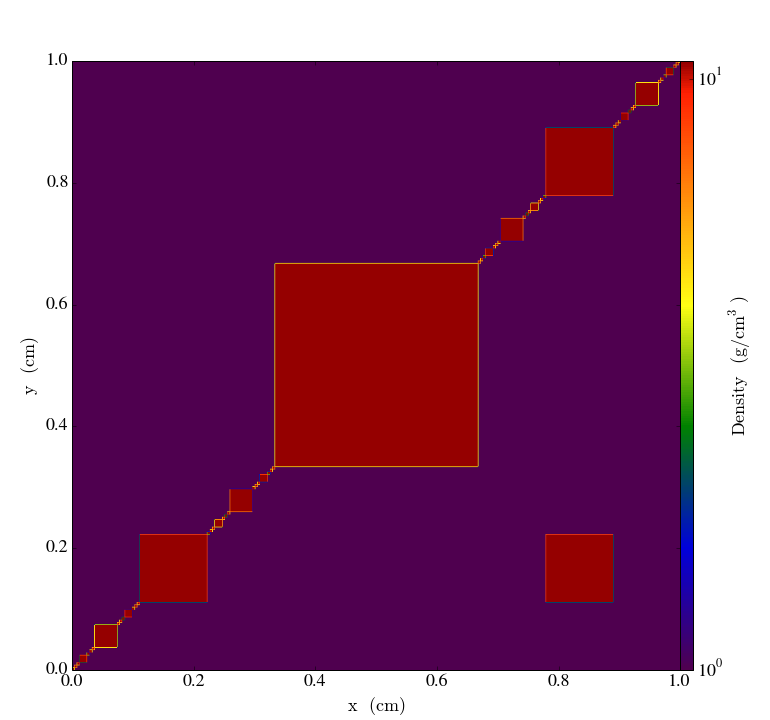

In [11]:
pf = PyneMoabHex8StaticOutput(m)
s = SlicePlot(pf, 'z', 'density', origin='native')
s.display()

## Computed Tags

Computed tags - also known as 'derived fields' - are a way of having a lazily evaluated 'virtual tag.'  A computed tag is defined with a function, lambda, or any other callable object.  The function must have the following interface:

```python
def f(mesh, i):
    """mesh is a pyne.mesh.Mesh() object and i is the volume element index
    to compute.
    """
    # ... do some work ...
    return anything_you_want
```

Here is a somewhat silly example which squares the density.  

In [12]:
m.density2 = ComputedTag(lambda mesh, i: mesh.density[i]**2)

Note that the bounds on the color bar have changed.


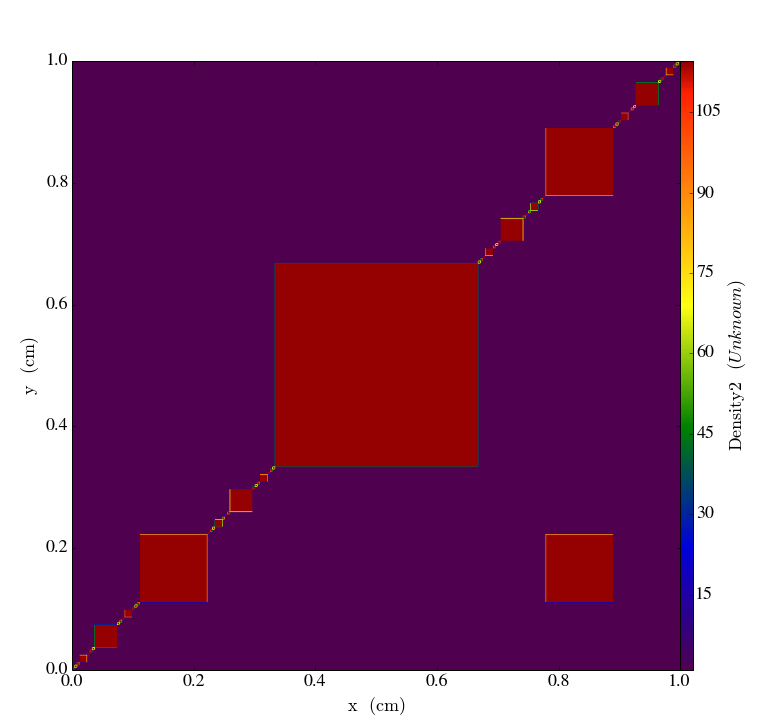

In [13]:
pf = PyneMoabHex8StaticOutput(m)
s = SlicePlot(pf, 'z', 'density2', origin='native')
s.display()

Here is a more serious example which uses PyNE's cross section tools to compute the one-group total cross section $\sigma_t$ everywhere on the mesh.

In [14]:
m.sigma_t = ComputedTag(lambda mesh, i: sigma_t(mesh.mats[i], group_struct=[10.0, 1e-6], phi_g=[1.0])[0])


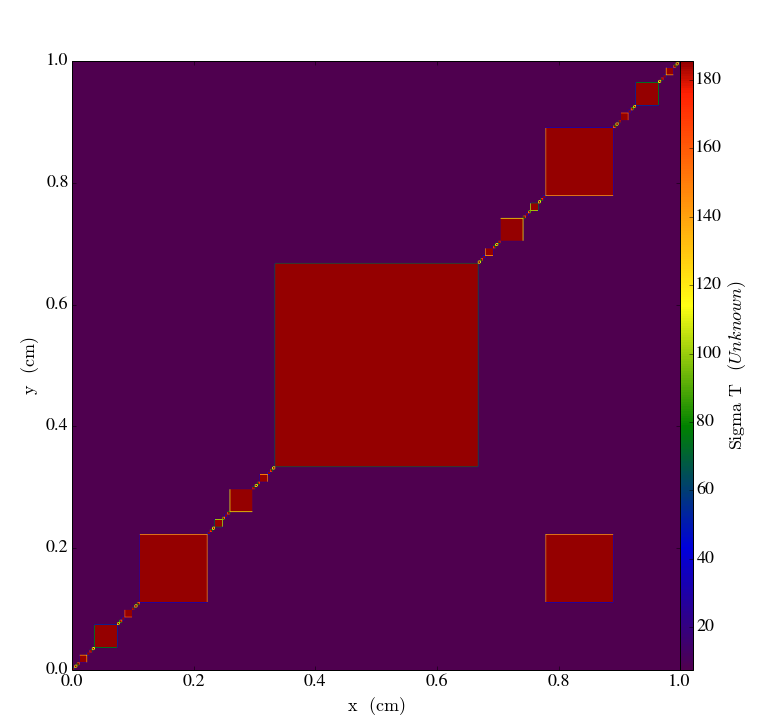

In [15]:
pf = PyneMoabHex8StaticOutput(m)
s = SlicePlot(pf, 'z', 'sigma_t', origin='native')
s.display()

Yes, that was only one line of code.